# EDA Tips dataset

In [283]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tipsdata import TipsData
from tipspipe import TipsPipe

plt.style.use('bmh')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data download
Data is downloaded  using the TipsData class. It checks if data exists, if not sets up file structure and downloads data to raw folder.The class can return raw data or data split in train, val and test. Since the dataset is clean there is no need for a preprocess pipeline.

In [284]:
dataset = TipsData()
dataset.prepare_data(train_split = 0.8, val_split = 0.2, test_split = 0.)
dataset.setup()

Returns the full raw dataset in a dataframe with features and labels in XY, only features in X and only lables in y.
Checking table properities shape, feature names and type and label name. 

In [285]:
XY, X,y = dataset.get_raw_data()

print(f'X shape: {X.shape}, y shape: {y.shape}')
print(f'X columns: {X.columns}\n')
print(f'X feature types: \n {X.info()}\n')
print(f'y label type: \n {y.info()}')

X shape: (244, 6), y shape: (244, 1)
X columns: Index(['tip', 'sex', 'smoker', 'day', 'time', 'g_size'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tip     244 non-null    float64
 1   sex     244 non-null    object 
 2   smoker  244 non-null    object 
 3   day     244 non-null    object 
 4   time    244 non-null    object 
 5   g_size  244 non-null    int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 11.6+ KB
X feature types: 
 None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB
y label type: 
 None


Get unique categorical classes.

In [286]:
#Get unique values
disc_feature_list = X.select_dtypes(exclude='float64').columns
disc_dict = {}
for i in disc_feature_list:
    print(f'{i}: {X[i].unique()}')
    disc_dict[i] = X[i].unique()

sex: ['Female' 'Male']
smoker: ['No' 'Yes']
day: ['Sun' 'Sat' 'Thur' 'Fri']
time: ['Dinner' 'Lunch']
g_size: [2 3 4 1 6 5]


Check class balance. Some of the features are quite imbalanced, however, the dataset is too small to downsample so we use it as is.

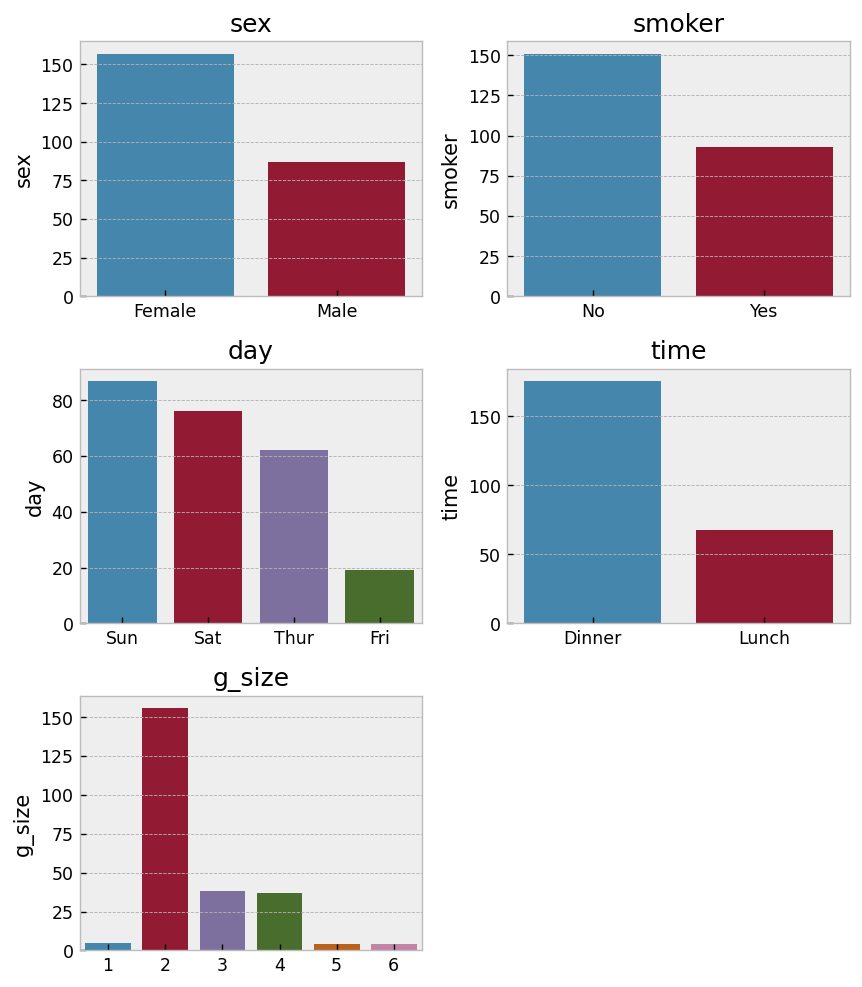

In [287]:
#Check class balance

plt.figure(figsize=(7,8), dpi=125)
for i,k in enumerate(disc_dict):
    plt.subplot(3,2,i+1)
    sns.barplot(x=disc_dict[k], y=X[k].value_counts())
    plt.title(k)
    plt.tight_layout()

plt.show()

Check categorical feature's correlation to the label. Based on this we can use this to do feature selection.

This dataset is small enough so we could run all combinations, however, here we will proceed with our selection.

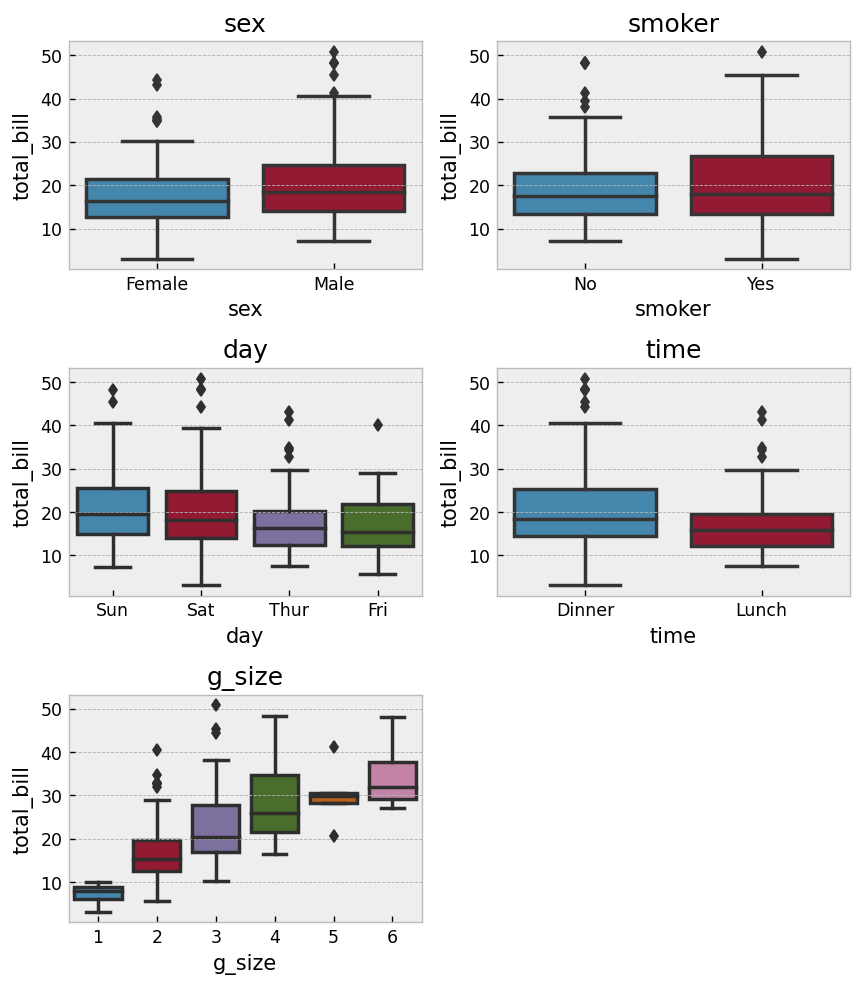

In [288]:
yy = 'total_bill'

plt.figure(figsize=(7,8), dpi=125)
for i,k in enumerate(disc_dict):
    plt.subplot(3,2,i+1)
    sns.boxplot(x=XY[k], y=yy, data=XY)
    plt.title(k)
    plt.tight_layout()

plt.show()

The only feature that seems to have any larger effect on total_bill is the group_size (g_size). In the final model I will also include time. I did some test and empirically it reduced metrics. 

Next we check the continuous features. First the distribution and then correlation.

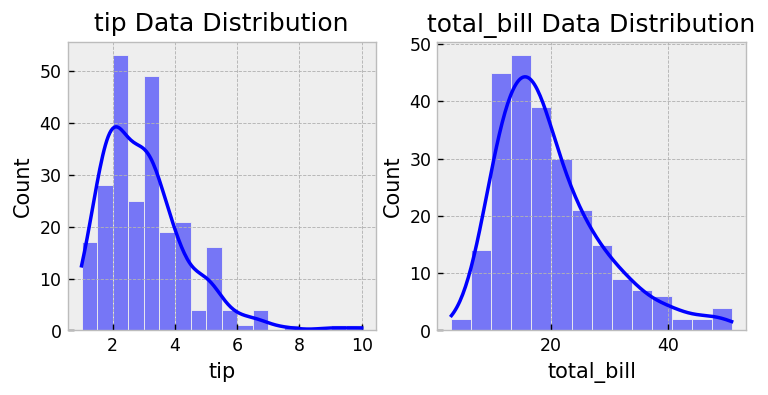

In [289]:
# Check distribution of continuous features

plt.figure(figsize=(7,3), dpi=125)
plt.subplot(1,2,1)
sns.histplot(data=XY, x='tip', kde=True)
plt.title('tip Data Distribution')

plt.subplot(1,2,2)
sns.histplot(data=XY, x='total_bill', kde=True)
plt.title('total_bill Data Distribution')
plt.show()

Both correlations look skewed and might benefit from transformation

0.6757341092113647


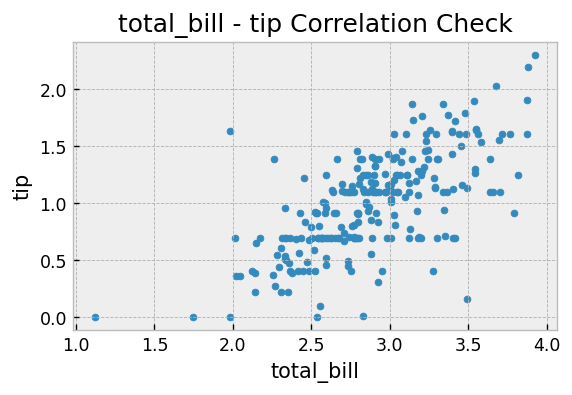

In [290]:
from scipy.stats import pearsonr

corr, _ = pearsonr(XY['total_bill'].to_numpy(),XY['tip'].to_numpy())
print(corr)

a = np.log(XY['total_bill'].to_numpy())
b = np.log(XY['tip'].to_numpy())

plt.figure(figsize=(5,3), dpi=125)
plt.scatter(a,b, s=15)
plt.xlabel("total_bill")
plt.ylabel("tip")
plt.title('total_bill - tip Correlation Check')
plt.show()

Correlation between the feature tip and the label total_bill is 0.68, which is medium to high strength. In the scatterplot we also see a clear correlation. This is good so we include the feature in the model.

## Modeling

### Data Pipeline 
The pipeline object will one-hot encode categorical features, scale ordinal and and do scaling and log-transform on numerical. From our feature selection we decided to retain time, tip and g_size. We run them in the pipeline and create a sklearn pipeline transformation object as well as transformed datasets for xtrain and xval.

In [291]:
import logging

logging.basicConfig(
    filename='training.log',
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
)

In [292]:
#Instanciate pipeline object
lr_pipe = TipsPipe()
# Create sklearn pipeline 
lr_pipe.make_preprocessor(cat_list=['time'], num_list=['tip'], count_list=['g_size'], pass_list=[])
# Get datasets
x,y = dataset.get_train_data()
xval, yval = dataset.get_val_data()
lr_pipe.train_pipe()
xtrain_pipe = lr_pipe.transform_data(x)
xval_pipe = lr_pipe.transform_data(xval)

I explore the linear models in sklearn with and without regularization. I use the pipeline object created above, add in the model and fit it with the data subsets from the data object. I print out r2, rmse, mae and mape metric. All of them are useful in their own way but I like rmse and mae because they give and average error in the same unit as the label. 

In [293]:
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet, RidgeCV, Lasso
from sklearn.pipeline import Pipeline
import joblib
import pathlib 

DATA_DIR = pathlib.Path().resolve() / "data"

regressors = {'Linear_regression': LinearRegression(), 'Ridge': RidgeCV(), 'Lasso': Lasso(alpha=0.001), 'Elasticnet': ElasticNet(alpha=0.1, l1_ratio=0.4)}
preds_lin = {}
for k,v in regressors.items():
    lin_pipe = Pipeline(steps=[lr_pipe.get_preprocessor(), ('model',v)])

    lin_pipe.fit(x,y)

    fname = DATA_DIR / str(k + '.joblib')
    joblib.dump(lin_pipe, fname)
    
    y_hat = lin_pipe.predict(xval)
    
    r2 = r2_score(yval, y_hat)
    rmse1 = np.sqrt(mean_squared_error(yval, y_hat))
    mae = mean_absolute_error(yval, y_hat)
    mape = mean_absolute_percentage_error(yval, y_hat)
    print(f'{k} model r2 score: {r2:.3f}, rmse: {rmse1:.3f}, mae: {mae:.3f}, mape: {mape:.3f}')
    
    logging.info(f'\nTrained model {k}, \nparameters: {lin_pipe[-1]}, \nmodel r2 score: {r2:.3f}, rmse: {rmse1:.3f}, mae: {mae:.3f}, mape: {mape:.3f}')

    preds_lin[k] = np.array(y_hat).reshape(len(y_hat),1)

Linear_regression model r2 score: 0.516, rmse: 6.608, mae: 4.927, mape: 0.251
Ridge model r2 score: 0.515, rmse: 6.610, mae: 4.959, mape: 0.255
Lasso model r2 score: 0.515, rmse: 6.609, mae: 4.928, mape: 0.251
Elasticnet model r2 score: 0.512, rmse: 6.635, mae: 5.002, mape: 0.259


The linear regression without regulatization seems margianlly better than the rest.

Plotting some graphs to examine the residuals.

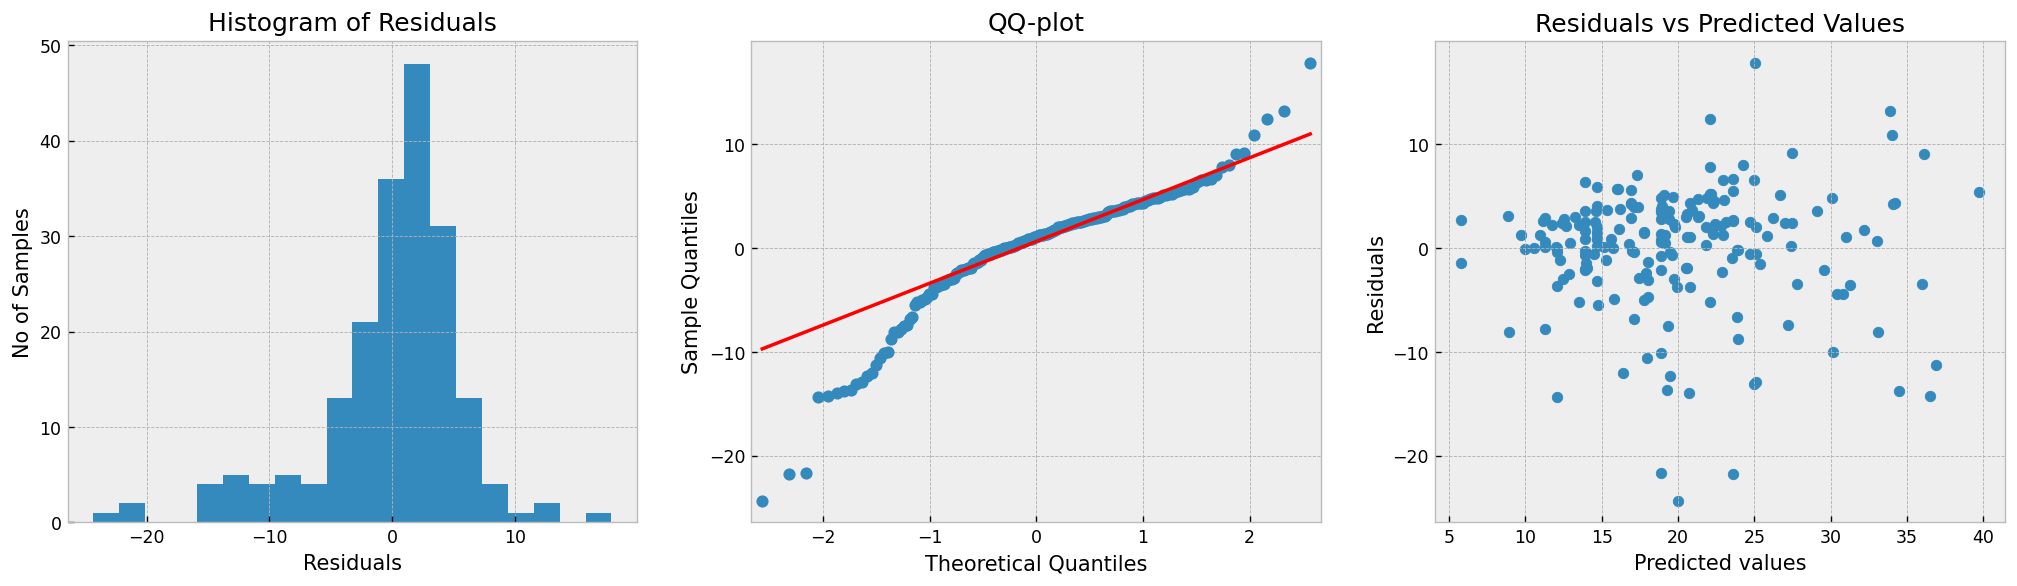

In [294]:
# Add residual normality check
import statsmodels.api as sm

model = joblib.load('data/Linear_regression.joblib')

pred_train = model.predict(x)
residuals = pred_train - y.to_numpy()

fig = plt.figure(figsize=(20,5), dpi=125)
ax1 = fig.add_subplot(1,3,1)
plt.hist(residuals, bins=20)
ax1.set_xlabel('Residuals')
ax1.set_ylabel('No of Samples')
ax1.set_title('Histogram of Residuals')

ax2 = fig.add_subplot(1,3,2)
sm.qqplot(residuals[:,0], line='q', ax=ax2)
ax2.set_title('QQ-plot')

ax3 = fig.add_subplot(1,3,3)
ax3.scatter(pred_train, residuals)
ax3.set_xlabel("Predicted values")
ax3.set_ylabel("Residuals")
ax3.set_title("Residuals vs Predicted Values")
fig.show()

The histogram and Residuals vs Predicted seems ok. The qqplot is a little bit of for the highs and the lows. We can understand that from thinking about the data, people eating at dinner time but not having mains will have a very low bill. However, discarding these will improve the training metrics but not predictions, since instances of this will happen again. So we accept the model as is.

Next I will see if I can improve the model by log-transforming the label. I use a SK-learn pipeline that's wrapped in my class. This returns the full pipeline/model object and the only takes a dataset. 

In [295]:
x,y = dataset.get_train_data()
xval, yval = dataset.get_val_data()
tt_pipe = TipsPipe()
regressors = {'Linear_regression': LinearRegression(), 'Ridge': RidgeCV(), 'Lasso': Lasso(alpha=0.001), 'Elasticnet': ElasticNet(alpha=0.1, l1_ratio=0.4)}
preds_tt = {}
for k,v in regressors.items():
    tt_linreg = tt_pipe.make_preprocessor2(cat_list=['time'], num_list=['tip'], 
                                           count_list=['g_size'], pass_list=[], model=v)
    fname = DATA_DIR / str('tt' + k + '.joblib')
    joblib.dump(tt_linreg, fname)
    y_hat = tt_linreg.predict(xval)
    
    r2 = r2_score(yval, y_hat)
    rmse1 = np.sqrt(mean_squared_error(yval, y_hat))
    mae = mean_absolute_error(yval, y_hat)
    mape = mean_absolute_percentage_error(yval, y_hat)
    print(f'{k} model r2 score: {r2:.3f}, rmse: {rmse1:.3f}, mae: {mae:.3f}, mape: {mape:.3f}')

    logging.info(f'\nTrained model {k}, \nparameters: {tt_linreg.regressor_[-1]}, \nmodel r2 score: {r2:.3f}, rmse: {rmse1:.3f}, mae: {mae:.3f}, mape: {mape:.3f}')
    preds_tt[k] = np.array(y_hat).reshape(len(y_hat),1)

Linear_regression model r2 score: 0.530, rmse: 6.512, mae: 4.760, mape: 0.238
Ridge model r2 score: 0.528, rmse: 6.522, mae: 4.782, mape: 0.240
Lasso model r2 score: 0.529, rmse: 6.516, mae: 4.767, mape: 0.238
Elasticnet model r2 score: 0.508, rmse: 6.656, mae: 4.934, mape: 0.251


The result is a little bit better than previous model. Again the linear regression model is marginally better.

Again we can look at the residuals.

['log_nums__tip' 'nums__g_size' 'cats__time_Lunch']


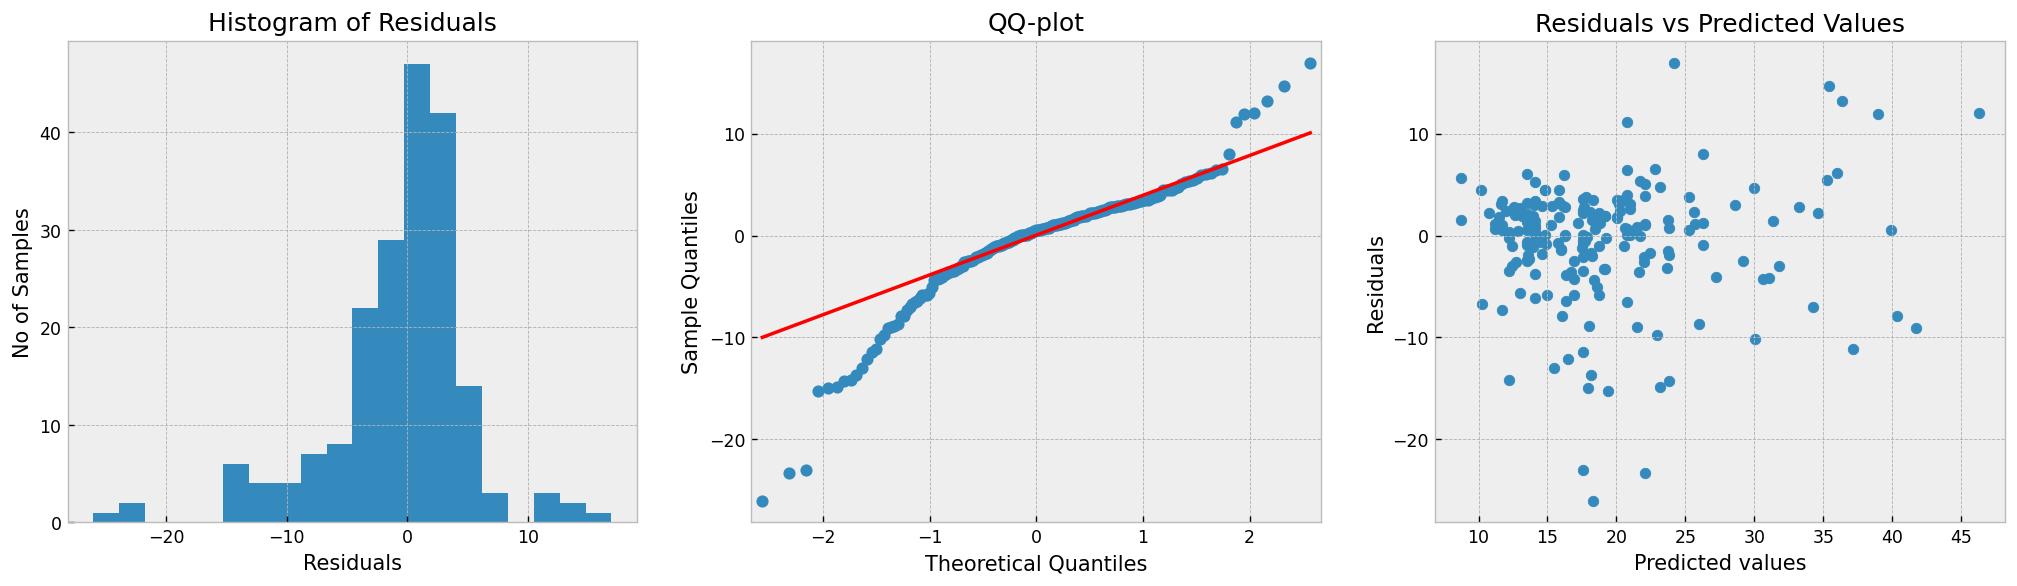

In [296]:
# Add residual normality check
import statsmodels.api as sm

model = joblib.load('data/ttLinear_regression.joblib')
print(model.regressor_[:-1].get_feature_names_out())

pred_train = model.predict(x)
residuals = pred_train - y.to_numpy()

fig = plt.figure(figsize=(20,5), dpi=125)
ax1 = fig.add_subplot(1,3,1)
plt.hist(residuals, bins=20)
ax1.set_xlabel('Residuals')
ax1.set_ylabel('No of Samples')
ax1.set_title('Histogram of Residuals')

ax2 = fig.add_subplot(1,3,2)
sm.qqplot(residuals[:,0], line='q', ax=ax2)
ax2.set_title('QQ-plot')

ax3 = fig.add_subplot(1,3,3)
ax3.scatter(pred_train, residuals)
ax3.set_xlabel("Predicted values")
ax3.set_ylabel("Residuals")
ax3.set_title("Residuals vs Predicted Values")
fig.show()

They look similar as before. With the same caveat as before we accept the model. However, we can dig a little bit deeper and look at the most extreme values (high and low) to seem if there is a pattern.

I find the cut off values and visualize in a scatter plot.

5% largest neg error: -6.07,
95% largest pos error: 12.36


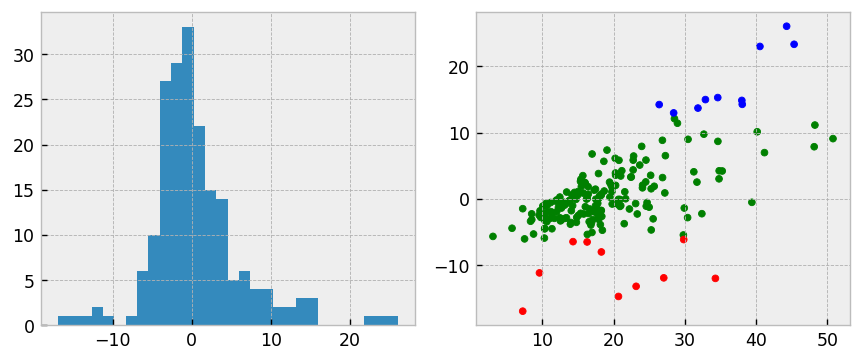

In [297]:

pred_train = model.predict(x)
res_error = y - pred_train

error_arr = np.concatenate((y, pred_train, res_error, x), axis=1)

er_df = pd.DataFrame(data=error_arr, columns=['y', 'pred','error'] + x.columns.to_list())

large_neg_res = res_error.quantile(.05)[0]
large_pos_res = res_error.quantile(.95)[0]

def col_fcn(row):
    if row['error'] < large_neg_res:
        return 'red'
    elif row['error'] > large_pos_res:
        return 'blue'
    else: return 'green'

er_df['color'] = er_df.apply(col_fcn, axis=1)


print(f'5% largest neg error: {large_neg_res:.2f},\n95% largest pos error: {large_pos_res:.2f}')

color_list = ['red', 'green', 'blue']

plt.figure(figsize=(7,3), dpi=125)
plt.subplot(1,2,1)
plt.hist(res_error, bins=30)

plt.subplot(1,2,2)
plt.scatter(y, res_error, color = er_df.color.to_list(), s=15)
plt.tight_layout()
plt.show()


We can get a table with the features for these extreme values and see if there is any clear trend.

In [298]:
display(er_df[(er_df['error'] > large_pos_res) | (er_df['error'] < large_neg_res)].sort_values(by=['color', 'error'], ascending=True))

,y,pred,error,tip,sex,smoker,day,time,g_size,color
192,28.44,15.478738,12.961262,2.56,Male,Yes,Thur,Lunch,2,blue
173,31.85,18.159465,13.690535,3.18,Male,Yes,Sun,Dinner,2,blue
57,26.41,12.192835,14.217165,1.5,Female,No,Sat,Dinner,2,blue
112,38.07,23.815145,14.254855,4.0,Male,No,Sun,Dinner,3,blue
56,38.01,23.165198,14.844802,3.0,Male,Yes,Sat,Dinner,4,blue
175,32.9,17.929022,14.970978,3.11,Male,Yes,Sun,Dinner,2,blue
179,34.63,19.356674,15.273326,3.55,Male,Yes,Sun,Dinner,2,blue
184,40.55,17.564222,22.985778,3.0,Male,Yes,Sun,Dinner,2,blue
182,45.35,22.039115,23.310885,3.5,Male,Yes,Sun,Dinner,3,blue
102,44.3,18.267804,26.032196,2.5,Female,Yes,Sat,Dinner,3,blue


I can't see any clear trend, we can calculate the correlation between residual and tip and visualize it for the discrete variables.

-0.03817664667898743


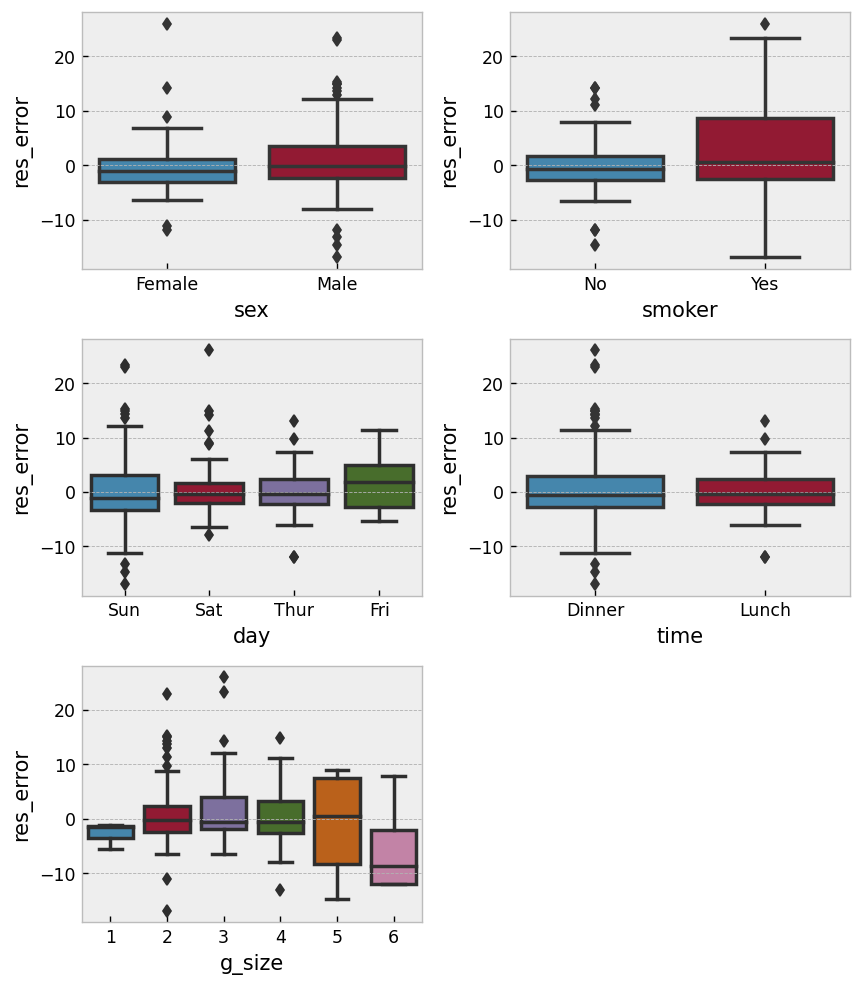

In [299]:
x['res_error'] = res_error['total_bill']

corr, _ = pearsonr(x['res_error'].to_numpy(),x['tip'].to_numpy())
print(corr)

plt.figure(figsize=(7,8), dpi=125)
for i,k in enumerate(disc_dict):
    plt.subplot(3,2,i+1)
    sns.boxplot(x=x[k], y='res_error', data=x)
    plt.tight_layout()

plt.show()

There doesn't seem to be any exaplanatory value left in the residual.

## Non-linear model XGBoost regression
Next I tried XGBoost to see if I could improve the metrics. I used the pipeline to transform the features, which are the fed into the XGB regressor.

In [300]:
xgb_pipe = TipsPipe()
xgb_pipe.make_preprocessor(cat_list=['sex','smoker','day','time'], num_list=['tip'], count_list=['g_size'], pass_list=[])

x,y = dataset.get_train_data()
xval, yval = dataset.get_val_data()
xgb_pipe.train_pipe()
xtrain_pipe = xgb_pipe.transform_data(x)
xval_pipe = xgb_pipe.transform_data(xval)

features = xgb_pipe.get_pipe()['preprocessor'].get_feature_names_out()
feature_names = [names for names in features]
print(feature_names)

['log_nums__tip', 'nums__g_size', 'cats__sex_Male', 'cats__smoker_Yes', 'cats__day_Sat', 'cats__day_Sun', 'cats__day_Thur', 'cats__time_Lunch']


Tree models are very robust and don't require data to be transformed, but in this notebook I run them through the pipeline.

After some initial testing, I found that the best validation is found after 6 rounds. So I stopped it at that point to evaluate the model.

In [301]:
from xgboost import XGBRegressor

#Test model
eval_set = [(xtrain_pipe,y), (xval_pipe, yval)]
eval_metrics = ['mae']

model = XGBRegressor(use_label_encoder=False, n_estimators=6)

xgb_trained = model.fit(xtrain_pipe,y,
             eval_set=eval_set,
             eval_metric=eval_metrics,
             verbose=True)


logging.info(f'\nTrained model xgb_trained, \nparameters: {xgb_trained}, \nmodel r2 score: {r2:.3f}, rmse: {rmse1:.3f}, mae: {mae:.3f}, mape: {mape:.3f}')

[0]	validation_0-mae:13.73855	validation_1-mae:13.50969
[1]	validation_0-mae:9.88998	validation_1-mae:9.83238
[2]	validation_0-mae:7.15598	validation_1-mae:7.19340
[3]	validation_0-mae:5.34494	validation_1-mae:5.66440
[4]	validation_0-mae:4.15764	validation_1-mae:4.95919
[5]	validation_0-mae:3.43744	validation_1-mae:4.73040


However, an mae of 4.7 is about the same as the linear model. So because of simplicity I will keep the linear model.

Tree models can be used for feature selection, so I looked at the weight of the features in the XGB model

[0.27880418 0.41353115 0.05695689 0.06842218 0.03553468 0.14154032
 0.00521053 0.        ]


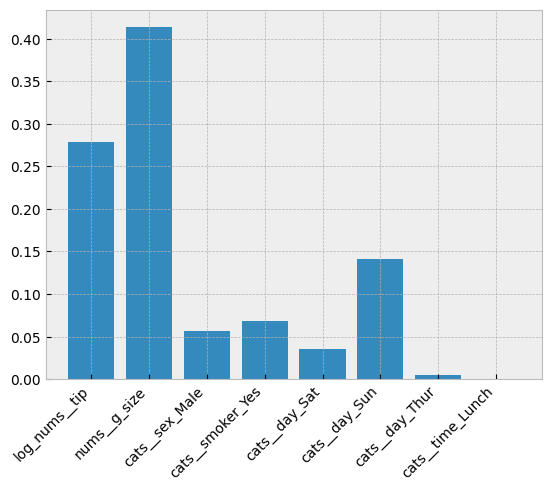

In [302]:
print(xgb_trained.feature_importances_)

plt.figure()
plt.bar(features, xgb_trained.feature_importances_)
plt.xticks(rotation=45, ha='right')
plt.show()

We can see the tips and g_size are the most important. This is the same result we saw earlier in the eda. Time is, strangely, at 0 which seems to make it useless. However, testing showed that it improved the linear model, so I keep it in.

Using shap gives the same result.

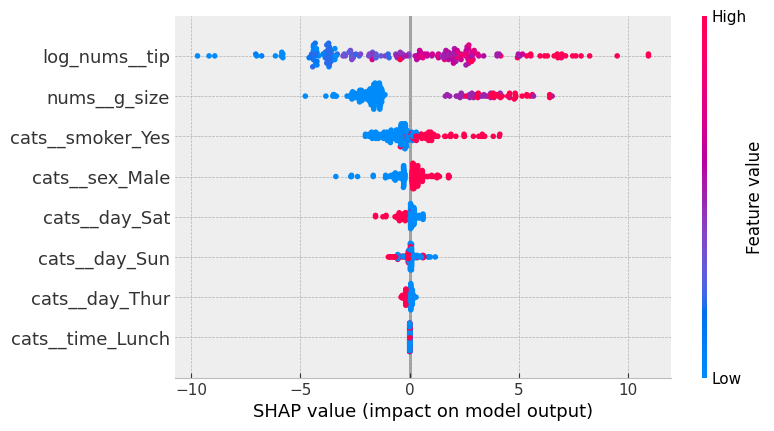

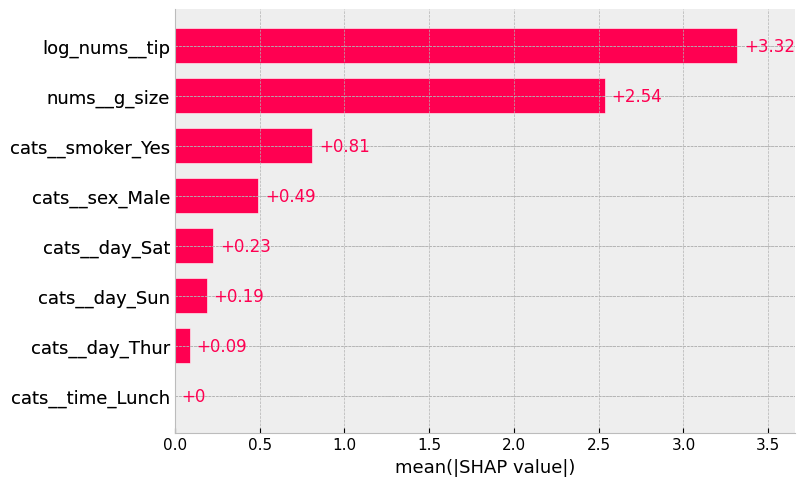

In [303]:
import shap
explainer = shap.Explainer(xgb_trained, feature_names=feature_names)
shap_values = explainer(xtrain_pipe)
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)